In [1]:
# Preliminaries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import networkx as nx
import theano
import theano.tensor as tt
import math 
from matplotlib.offsetbox import AnchoredText
import theano
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"


In [2]:
# Load the data
g1 = nx.read_graphml('../../fep-maps/graphml/CDK2_Blake_samegraph_051118_seed3_out.graphml')
g2 = nx.read_graphml('../../fep-maps/graphml/ERK2_Blake_samegraph_051118_seed3_out.graphml')
list_of_graphs = [g1, g2]

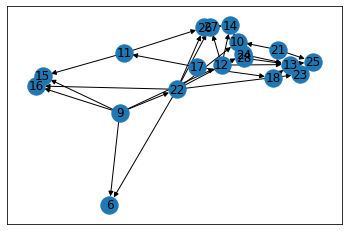

In [3]:
nx.draw_networkx(g1, pos=nx.spring_layout(g1), with_labels=True)

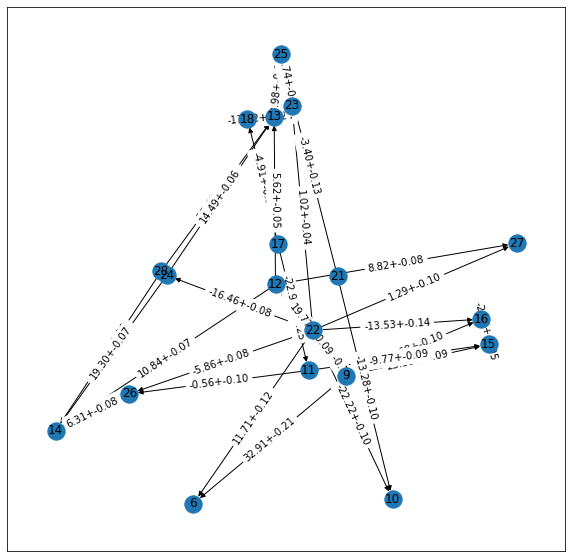

In [4]:
plt.figure(figsize=[10,10])
pos = nx.spring_layout(g1)
nx.draw_networkx(g1, pos=pos, with_labels=True)
edge_labels = dict()
for (n1,n2) in g1.edges:
    e = g1.edges[(n1,n2)]
    edge_labels[(n1,n2)] = '%.2f+-%.2f' % (e['complex_dg_val'], e['complex_dg_unc']);
nx.draw_networkx_edge_labels(g1, pos=pos, edge_labels=edge_labels);

In [5]:
g1.remove_node('9')
g2.remove_node('9')
nligands = len(g1.nodes)
print(nligands)
ligand_index = { str(node) : index for (index, node) in enumerate(g1.nodes) }
reference_ligand = [ str(node) for node in g1.nodes ][0] # We will use the same reference ligand in all calculations
print('Reference ligand: {}'.format(reference_ligand))

18
Reference ligand: 17


In [6]:
nedges = len(g1.edges)
print(nedges)
G_to_DeltaG = np.zeros([nedges, nligands])
DeltaG_BAR_target1_complex_calc = np.zeros([nedges])
dDeltaG_BAR_target1_complex_calc = np.zeros([nedges])
DeltaG_BAR_target1_solvent_calc = np.zeros([nedges])
dDeltaG_BAR_target1_solvent_calc = np.zeros([nedges])
DeltaDeltaG_exp_target1 = np.zeros([nedges])
DeltaDeltaG_CycleClosure_ij_target1 = np.zeros([nedges])
DeltaDeltaG_CycleClosure_ij_target2 = np.zeros([nedges])
for edge_index, edge in enumerate(g1.edges):
    ligand_i, ligand_j = edge
    #if ligand_i != reference_ligand:
    i = ligand_index[ligand_i]
    G_to_DeltaG[edge_index,i] = -1.0
    #if ligand_j != reference_ligand:
    j = ligand_index[ligand_j]
    G_to_DeltaG[edge_index,j] = +1.0
    
    DeltaG_BAR_target1_complex_calc[edge_index] = g1.edges[edge]['complex_dg_val']
    dDeltaG_BAR_target1_complex_calc[edge_index] = g1.edges[edge]['complex_dg_unc']
    DeltaG_BAR_target1_solvent_calc[edge_index] = g1.edges[edge]['solvent_dg_val']
    dDeltaG_BAR_target1_solvent_calc[edge_index] = g1.edges[edge]['solvent_dg_unc']
    DeltaDeltaG_exp_target1[edge_index] = g1.edges[edge]['exp_ddg']
    DeltaDeltaG_CycleClosure_ij_target1[edge_index] = g1.edges[edge]['ccc_ddg_val']


DeltaG_BAR_target2_complex_calc = np.zeros([nedges])
dDeltaG_BAR_target2_complex_calc = np.zeros([nedges])
DeltaG_BAR_target2_solvent_calc = np.zeros([nedges])
dDeltaG_BAR_target2_solvent_calc = np.zeros([nedges])
DeltaDeltaG_exp_target2 = np.zeros([nedges])
for edge_index, edge in enumerate(g2.edges):
    ligand_i, ligand_j = edge
    DeltaG_BAR_target2_complex_calc[edge_index] = g2.edges[edge]['complex_dg_val']
    dDeltaG_BAR_target2_complex_calc[edge_index] = g2.edges[edge]['complex_dg_unc']
    DeltaG_BAR_target2_solvent_calc[edge_index] = g2.edges[edge]['solvent_dg_val']
    dDeltaG_BAR_target2_solvent_calc[edge_index] = g2.edges[edge]['solvent_dg_unc']
    DeltaDeltaG_exp_target2[edge_index] = g2.edges[edge]['exp_ddg']
    DeltaDeltaG_CycleClosure_ij_target2[edge_index] = g2.edges[edge]['ccc_ddg_val']

DeltaG_exp_1 = np.zeros([nligands])
for node_index,node in enumerate(g1.nodes):
    DeltaG_exp_1[node_index] = g1.nodes[node]['exp_dg']

DeltaG_exp_2 = np.zeros([nligands])
for node_index,node in enumerate(g2.nodes):
    DeltaG_exp_2[node_index] = g2.nodes[node]['exp_dg']


25


In [7]:
sd_G = np.zeros([nligands])
for i,num in enumerate(sd_G): 
    if i == 0:
        sd_G[i] = 1.0
    else: 
        sd_G[i] = 25.0
sd_G

array([ 1., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25.])

In [8]:
model = pm.Model()
with model:
    experimental_error=0.3
    # Implement absolute G for target 1 
    G_FEP_i_target1_complex = pm.Normal('G_FEP_i_target1_complex', mu=0.0, sd=sd_G, shape=(nligands,))
    G_FEP_i_target1_solvent = pm.Normal('G_FEP_i_target1_solvent', mu=0.0, sd=sd_G, shape=(nligands,))
    alpha = pm.HalfFlat('alpha')
    
    # Correction term for dummy atoms 
    c_FEP_ij_target1 = pm.Normal('c_FEP_ij_target1', mu=0.0, sd=25.0, shape=(nedges,))
    
    # Calculated BAR Delta G for each edge and phase for target 1
    DeltaG_BAR_target1_complex = pm.Normal('DeltaG_BAR_target1_complex', mu=tt.dot(G_to_DeltaG, G_FEP_i_target1_complex)+c_FEP_ij_target1, 
                                           sd=alpha*dDeltaG_BAR_target1_complex_calc, observed=DeltaG_BAR_target1_complex_calc, shape=(nedges,))
    DeltaG_BAR_target1_solvent = pm.Normal('DeltaG_BAR_target1_solvent', mu=tt.dot(G_to_DeltaG, G_FEP_i_target1_solvent)+c_FEP_ij_target1, 
                                           sd=alpha*dDeltaG_BAR_target1_solvent_calc, observed=DeltaG_BAR_target1_solvent_calc, shape=(nedges,))
    DeltaDeltaG_FEP_ij_target1 = pm.Deterministic('DeltaDeltaG_FEP_ij_target1', 
                                                  tt.dot(G_to_DeltaG, G_FEP_i_target1_complex) - tt.dot(G_to_DeltaG, G_FEP_i_target1_solvent))
    
    # Calculated BAR delta G for each edge and phase for target 2 
    G_FEP_i_target2_complex = pm.Normal('G_FEP_i_target2_complex', mu=0.0, sd=sd_G, shape=[nligands,])
    G_FEP_i_target2_solvent = pm.Normal('G_FEP_i_target2_solvent', mu=0.0, sd=sd_G, shape=[nligands,])
    c_FEP_ij_target2 = pm.Normal('c_FEP_ij_target2', mu=0.0, sd=25.0, shape=[nedges])
    DeltaG_BAR_target2_complex = pm.Normal('DeltaG_BAR_target2_complex', mu=tt.dot(G_to_DeltaG, G_FEP_i_target2_complex)+c_FEP_ij_target2, 
                                           sd=alpha*dDeltaG_BAR_target2_complex_calc, observed=DeltaG_BAR_target2_complex_calc, shape=(nedges,))
    DeltaG_BAR_target2_solvent = pm.Normal('DeltaG_BAR_target2_solvent', mu=tt.dot(G_to_DeltaG, G_FEP_i_target2_solvent)+c_FEP_ij_target2, 
                                           sd=alpha*dDeltaG_BAR_target2_solvent_calc, observed=DeltaG_BAR_target2_solvent_calc, shape=(nedges,))
    DeltaDeltaG_FEP_ij_target2 = pm.Deterministic('DeltaDeltaG_FEP_ij_target2', 
                                                  tt.dot(G_to_DeltaG, G_FEP_i_target2_complex) - tt.dot(G_to_DeltaG, G_FEP_i_target2_solvent))
        

In [9]:
with model: 
    
    # True and Experimental delta G for each target 
    DeltaG_true_exp_i_target1 = pm.Normal('DeltaG_true_exp_i_target1', mu=0.0, sd=50.0, shape=(nligands,))
    DeltaG_obs_exp_i_target1 = pm.Normal('DeltaG_obs_exp_i_target1', mu=DeltaG_true_exp_i_target1, sd=experimental_error, shape=(nligands,), observed=DeltaG_exp_1)
    DeltaDeltaG_true_exp_ij_target1 = pm.Deterministic('DeltaDeltaG_true_exp_ij_target1', tt.dot(G_to_DeltaG, DeltaG_true_exp_i_target1))

    DeltaG_true_exp_i_target2 = pm.Normal('DeltaG_true_exp_i_target2', mu=0.0, sd=50.0, shape=(nligands,))
    DeltaG_obs_exp_i_target2 = pm.Normal('DeltaG_obs_exp_i_target2', mu=DeltaG_true_exp_i_target2, sd=experimental_error, shape=(nligands,), observed=DeltaG_exp_2)
    DeltaDeltaG_true_exp_ij_target2 = pm.Deterministic('DeltaDeltaG_true_exp_ij_target2', tt.dot(G_to_DeltaG, DeltaG_true_exp_i_target2))
    

In [10]:
with model: 
     # Compute estimate of absolute binding free energies (with additive arbitrary offset)
    DeltaG_FEP_i_target1_no_offset = pm.Deterministic('DeltaG_FEP_i_target1_no_offset', G_FEP_i_target1_complex - G_FEP_i_target1_solvent)
    DeltaG_FEP_i_target2_no_offset = pm.Deterministic('DeltaG_FEP_i_target2_no_offset', G_FEP_i_target2_complex - G_FEP_i_target2_solvent)

    # Compute best-case shifted offsets of absolute binding free energies (with Schrodinger style offset)
    DeltaG_FEP_i_target1_schrodinger_offset = pm.Deterministic('DeltaG_FEP_i_target1_schrodinger_offset', DeltaG_FEP_i_target1_no_offset + DeltaG_true_exp_i_target1.mean() - DeltaG_FEP_i_target1_no_offset.mean())
    DeltaG_FEP_i_target2_schrodinger_offset = pm.Deterministic('DeltaG_FEP_i_target2_schrodinger_offset', DeltaG_FEP_i_target2_no_offset + DeltaG_true_exp_i_target2.mean() - DeltaG_FEP_i_target2_no_offset.mean())
    
    # Compute best-case dG errors 
    epsilon_i_target1_schrodinger = pm.Deterministic('epsilon_i_target1_schrodinger', DeltaG_FEP_i_target1_schrodinger_offset - DeltaG_true_exp_i_target1)
    epsilon_i_target2_schrodinger = pm.Deterministic('epsilon_i_target2_schrodinger', DeltaG_FEP_i_target2_schrodinger_offset - DeltaG_true_exp_i_target2)
    
    #error_likelihood = pm.DensityDist('error_liklihood', logp, observed={'rho':rho, 'sigma':sigma_FEP, 'epsilon_a':error_target1, 'epsilon_b':error_target2}, shape=(nedges,))
    rho_schrodinger = pm.Deterministic('rho_schrodinger', ((((epsilon_i_target1_schrodinger - epsilon_i_target1_schrodinger.mean()) * (epsilon_i_target2_schrodinger - epsilon_i_target2_schrodinger.mean())).mean()) /
                                   (epsilon_i_target1_schrodinger.std() * epsilon_i_target2_schrodinger.std())))

In [11]:
with model: 
    
    # Compute free energy differences between all pairs of ligands    
    DeltaDeltaG_FEP_allpairs_ij_target1 = pm.Deterministic('DeltaDeltaG_FEP_allpairs_ij_target1', DeltaG_FEP_i_target1_no_offset.dimshuffle(0, 'x') - DeltaG_FEP_i_target1_no_offset.dimshuffle('x', 0))
    DeltaDeltaG_FEP_allpairs_ij_target2 = pm.Deterministic('DeltaDeltaG_FEP_allpairs_ij_target2', DeltaG_FEP_i_target2_no_offset.dimshuffle(0, 'x') - DeltaG_FEP_i_target2_no_offset.dimshuffle('x', 0))
     
    # Compute experimental ddG differences for all pairs of ligands
    DeltaDeltaG_true_exp_allpairs_ij_target1 = pm.Deterministic('DeltaDeltaG_true_exp_allpairs_ij_target1', DeltaG_true_exp_i_target1.dimshuffle(0, 'x') - DeltaG_true_exp_i_target1.dimshuffle('x', 0))
    DeltaDeltaG_true_exp_allpairs_ij_target2 = pm.Deterministic('DeltaDeltaG_true_exp_allpairs_ij_target2', DeltaG_true_exp_i_target2.dimshuffle(0, 'x') - DeltaG_true_exp_i_target2.dimshuffle('x', 0))

    # Compute ddG errors for all pairs of ligands
    epsilon_ij_target1 = pm.Deterministic('epsilon_ij_target1', DeltaDeltaG_FEP_allpairs_ij_target1 - DeltaDeltaG_true_exp_allpairs_ij_target1)
    epsilon_ij_target2 = pm.Deterministic('epsilon_ij_target2', DeltaDeltaG_FEP_allpairs_ij_target2 - DeltaDeltaG_true_exp_allpairs_ij_target2)
    rho_allpairs = pm.Deterministic('rho_allpairs', ((((epsilon_ij_target1 - epsilon_ij_target1.mean()) * (epsilon_ij_target2 - epsilon_ij_target2.mean())).mean()) /
                                   (epsilon_ij_target1.std() * epsilon_ij_target2.std())))
    
    

In [12]:
with model:
    trace = pm.sample(draws=20000, tune=3000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [DeltaG_true_exp_i_target2, DeltaG_true_exp_i_target1, c_FEP_ij_target2, G_FEP_i_target2_solvent, G_FEP_i_target2_complex, c_FEP_ij_target1, alpha, G_FEP_i_target1_solvent, G_FEP_i_target1_complex]
100%|██████████| 23000/23000 [1:33:37<00:00,  4.09it/s]  
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


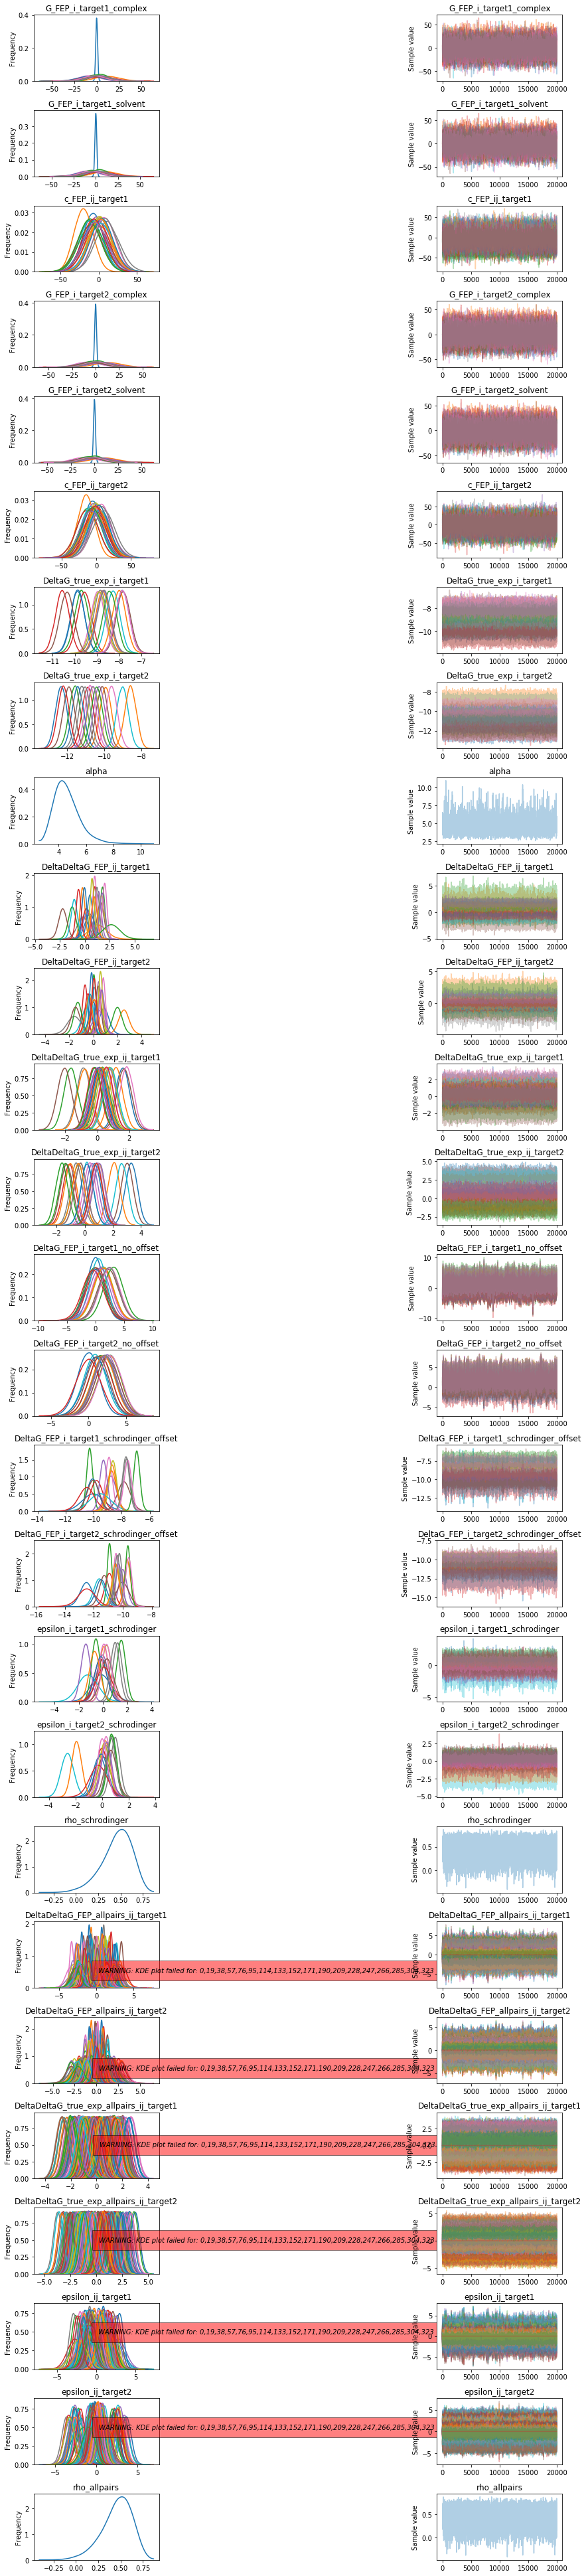

In [13]:
# Plot the posterior confidence interval for RMSE
_ = pm.traceplot(trace)

In [14]:
pm.summary(trace, varnames={'rho_schrodinger'})

,mean,sd,mc_error,hpd_2.5,hpd_97.5
rho_schrodinger,0.455073,0.16887,0.001507,0.106216,0.749393


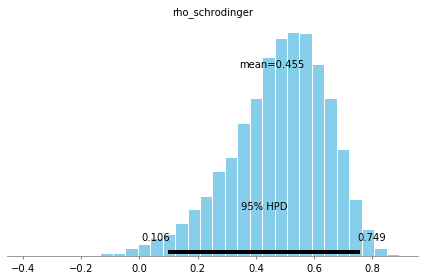

In [15]:
pm.plot_posterior(trace,varnames=['rho_schrodinger'])

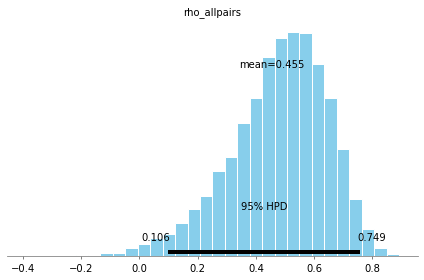

In [16]:
pm.plot_posterior(trace,varnames=['rho_allpairs'])

In [17]:
pm.save_trace(trace, directory='CDK2-ERK2-trace_ccparameter', overwrite=True)


'CDK2-ERK2-trace_ccparameter'

In [18]:
with model:
    trace = pm.load_trace('CDK2-ERK2-trace_ccparameter/')

<Figure size 504x432 with 0 Axes>

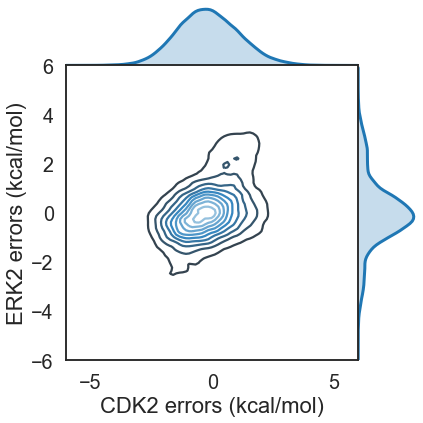

In [19]:
nsamples = trace['epsilon_ij_target1'].shape[0]
stride = 50
nelements_per_sample = int(nligands * (nligands-1)/2)
nelements = int(nelements_per_sample * nsamples/stride)
epsilon1 = np.zeros([nelements], np.float32)
epsilon2 = np.zeros([nelements], np.float32)
ligand_indices = np.triu_indices(nligands, k=1)
for (index, sample) in enumerate(range(0, nsamples, stride)):
    epsilon1[index*nelements_per_sample:(index+1)*nelements_per_sample] = trace['epsilon_ij_target1'][sample,ligand_indices[0],ligand_indices[1]].flatten()
    epsilon2[index*nelements_per_sample:(index+1)*nelements_per_sample] = trace['epsilon_ij_target2'][sample,ligand_indices[0],ligand_indices[1]].flatten()
    
fig = plt.figure(figsize=(7,6))
sns.set_context('talk',font_scale=1.2)
sns.set_style('white')
g=sns.JointGrid(epsilon1, epsilon2, space=0, xlim=[-6,6], ylim=[-6,6])
g.set_axis_labels('CDK2 errors (kcal/mol)', 'ERK2 errors (kcal/mol)', fontsize=22)
g = g.plot_joint(sns.kdeplot, cmap="Blues_d")
g = g.plot_marginals(sns.kdeplot, shade=True, lw=3)
g.savefig('epsilonjoint_cdk2_erk2_ccparameter.pdf', dpi=400)

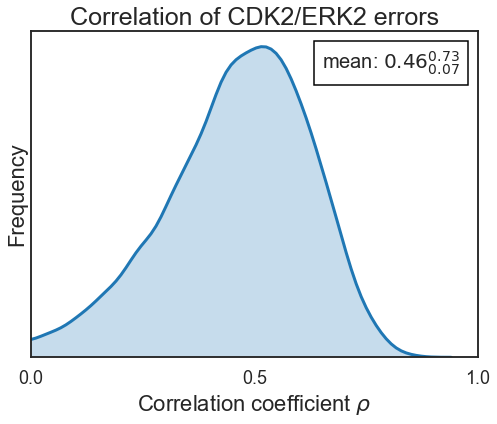

In [20]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
mean = trace['rho_allpairs']
sns.distplot(trace['rho_allpairs'], kde_kws={"lw": 3, 'shade': True}, hist=None)
text = AnchoredText('mean: $%.2f^{%.2f}_{%.2f}$' %(trace['rho_allpairs'].mean(), 
                                                                                 np.percentile(trace['rho_allpairs'], [2.5, 97.5])[1], 
                                                                                 np.percentile(trace['rho_allpairs'], [2.5, 97.5])[0]), loc=1, prop=dict(fontsize=20))
plt.xlim([0,1])
plt.yticks([])
plt.xticks([0, .5, 1],fontsize=18)
plt.title('Correlation of CDK2/ERK2 errors', fontsize=25)
plt.xlabel('Correlation coefficient $\\rho$', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
ax.add_artist(text)
plt.savefig('rho_cdk2_erk2_rep3_ccparameter.pdf', dpi=400)

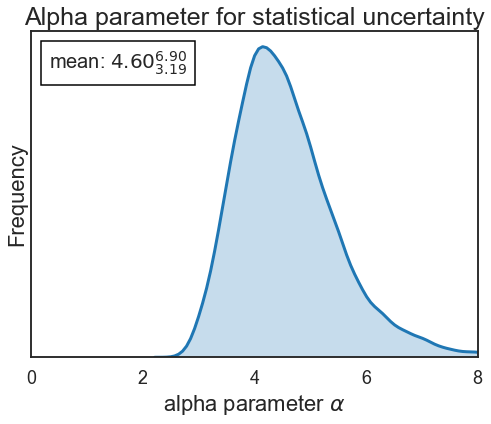

In [22]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
mean = trace['alpha']
sns.distplot(trace['alpha'], kde_kws={"lw": 3, 'shade': True}, hist=None)
text = AnchoredText('mean: $%.2f^{%.2f}_{%.2f}$' %(trace['alpha'].mean(), 
                                                                                 np.percentile(trace['alpha'], [2.5, 97.5])[1], 
                                                                                 np.percentile(trace['alpha'], [2.5, 97.5])[0]), loc=2, prop=dict(fontsize=20))
plt.xlim([0,8])
plt.yticks([])
plt.xticks([0, 2, 4,6,8],fontsize=18)
plt.title('Alpha parameter for statistical uncertainty', fontsize=25)
plt.xlabel('alpha parameter $\\alpha$', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
ax.add_artist(text)
plt.savefig('alpha_cdk2_erk2_rep3_ccparam.pdf', dpi=400)